# MultiNest sampling

This example demonstrates how to use MultiNest sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data.

[1] "MultiNest: an efficient and robust Bayesian inference tool for cosmology and particle physics."
Feroz, F., M. P. Hobson, and M. Bridges. Monthly Notices of the Royal Astronomical Society 398.4 (2009): 1601-1614.

First create fake data.

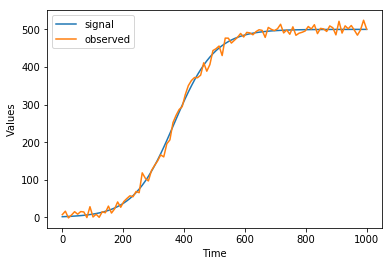

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt


# below implicitly assumes the following priors
# log_prior = pints.UniformLogPrior(
#     [0.01, 400, sigma * 0.5],
#     [0.02, 600, sigma * 1.5])
class ExampleModel(pints.ForwardModel):
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        params_transformed = np.copy(parameters)
        params_transformed[0] = (params_transformed[0] * 0.5 + 0.5) / 50
        params_transformed[1] = (params_transformed[1] * 200 + 400)
        return toy.LogisticModel().simulate(params_transformed, times) 
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

# Load a forward model
model = ExampleModel()

# Create some toy data
r = 0.5
k = 0.5
real_parameters = [r, k]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
sigma = 10
observed_values = signal_values + pints.noise.independent(sigma, signal_values.shape)

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

Create the nested sampler that will be used to sample from the posterior.

In [2]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, 10)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.0, 0.0],
    [1.0, 1.0])

# Create a nested ellipsoidal rejectection sampler
sampler = pints.NestedController(log_likelihood, log_prior, method=pints.MultinestSampler)

# Set number of iterations
sampler.set_iterations(8000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(1600)

sampler._sampler.set_f_s_threshold(1.3)

Run the sampler!

In [3]:
samples = sampler.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 8000
Total number of posterior samples: 1600
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.0 -inf          1               0             
0     181     0:00.0 -inf          1               0             
0     201     0:00.0 -inf          1               0             
0     221     

KeyboardInterrupt: 

## Plot posterior samples versus true parameter values (dashed lines)

In [ ]:
# Plot output
import pints.plot

pints.plot.histogram([samples], ref_parameters=[r, k])

plt.show()

## Plot posterior predictive simulations versus the observed data

In [ ]:
pints.plot.series(samples[:100], problem)
plt.show()

## Marginal likelihood estimate

In [ ]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))

## Effective sample size

In [ ]:
print('effective sample size = ' + str(sampler.effective_sample_size()))

# Egg box problem

In [4]:
class ExampleToy(pints.LogPDF):
    def __init__(self, sigma, r):
        self._sigma = sigma
        self._r = r
        self._log_toy = pints.toy.SimpleEggBoxLogPDF(self._sigma, self._r)

    def __call__(self, x):
        x1 = np.copy(x)
        x1[0] = -15 + 30 * x[0]
        x1[1] = -15 + 30 * x[1]
        return self._log_toy(x1)

    def n_parameters(self):
        return 2

In [5]:
log_pdf = ExampleToy(2, 4)
log_prior = pints.UniformLogPrior(
    [0.0, 0.0],
    [1.0, 1.0])

In [6]:
sampler = pints.NestedController(log_pdf, log_prior, method=pints.MultinestSampler)

# Set number of iterations
sampler.set_iterations(8000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(1600)

sampler._sampler.set_f_s_threshold(1.3)

In [7]:
samples = sampler.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 8000
Total number of posterior samples: 1600
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.0 -inf          1               0             
0     181     0:00.1 -inf          1               0             
0     201     0:00.1 -inf          1               0             
0     221     

KeyboardInterrupt: 

In [ ]:
sigma = 2
r = 4
log_pdf = pints.toy.SimpleEggBoxLogPDF(sigma, r)

# Contour plot of pdf
levels = np.linspace(-100, 0, 20)
x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x, y)
Z = [[np.exp(log_pdf([i, j])) for i in x] for j in y]

plt.figure()
plt.contour(X, Y, Z, colors='k')
plt.scatter(-15 + 30 * samples[:, 0], -15 + 30 * samples[:, 1], marker='.')
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.show()

In [ ]:
print('effective sample size = ' + str(sampler.effective_sample_size()))

In [ ]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))